In [1]:
# ==========================================================
# 0. Imports and devices
# ==========================================================
# General libraries
import h5py
import os
import shutil

# Parallelisation libraries
from joblib import Parallel, delayed
import multiprocessing as mp

mp.set_start_method("spawn", force=True) 

# Module functions
import ximinf.generate_sim as gsim
import ximinf.nn_train as nntr
import ximinf.nn_test as nnte

# Plot libraries
import matplotlib.pyplot as plt
import itertools
from matplotlib.colors import LinearSegmentedColormap

# Jax dedicated libraries
from flax import nnx
import optax
import jax
import jax.numpy as jnp # From this point on, there should not be numpy anymore but only jax.numpy
import jax.scipy as jsp



cpu = jax.devices("cpu")[0]
gpu = jax.devices("METAL")[0]
key = jax.random.PRNGKey(0)

W0000 00:00:1768406044.023402 3031151 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1768406044.065093 3031151 service.cc:145] XLA service 0x7f8e55982c80 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1768406044.065114 3031151 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1768406044.070004 3031151 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1768406044.070021 3031151 mps_client.cc:384] XLA backend will use up to 22906077184 bytes on device 0 for SimpleAllocator.


Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



In [2]:
# ==========================================================
# 1. Fixed configuration (unchanged)
# ==========================================================
file_path = "./data/sequential_dataset.h5"

if os.path.exists(file_path):
    os.remove(file_path)

# Directory to save posterior plots
save_dir = "./plots"

# Subdirectories for training and posterior plots
train_dir = os.path.join(save_dir, "training")
post_dir = os.path.join(save_dir, "posteriors")

# Remove existing directories if they exist
for d in [train_dir, post_dir]:
    if os.path.exists(d):
        shutil.rmtree(d)

# Recreate empty directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(post_dir, exist_ok=True)

M = 1000
z_max = 0.2


ranges = {
    'mabs': (-2, 2),
    'alpha': (-0.5, 0.0),
    'beta': (2.5, 4.0),
}

mabs_offset = -19.3


# columns = ['magobs', 'magobs_err','x1', 'x1_err', 'c', 'c_err', 'z']
columns = ['magobs','x1', 'c', 'z']

param_groups = [['mabs', 'alpha', 'beta']]
param_names = list(ranges.keys())
K = len(param_names)


Nsize_p = 128
Nsize_r = 256
dropout_rate = 0.05

In [3]:
class Phi(nnx.Module):
    """
    Neural network module for the Phi network in a Deep Set architecture.
    """
    def __init__(self, Nsize, n_cols, *, rngs):
        self.linear1 = nnx.Linear(n_cols, Nsize, rngs=rngs) #+n_params
        self.linear2 = nnx.Linear(Nsize, Nsize, rngs=rngs)
        self.linear3 = nnx.Linear(Nsize, Nsize, rngs=rngs)

    def __call__(self, data):
        h = data
        
        h = nnx.relu(self.linear1(h))
        h = nnx.relu(self.linear2(h))
        h = nnx.relu(self.linear3(h))
        return h


class Rho(nnx.Module):
    """
    Neural network module for the Rho network in a Deep Set architecture
    with separate LayerNorm for pooled features and theta.
    """
    def __init__(self, Nsize_p, Nsize_r, N_size_params, *, rngs):
        self.linear1 = nnx.Linear(Nsize_p + N_size_params, Nsize_r, rngs=rngs) #
        self.linear2 = nnx.Linear(Nsize_r, Nsize_r, rngs=rngs)
        self.linear3 = nnx.Linear(Nsize_r, 1, rngs=rngs)

    def __call__(self, dropout, pooled_features, params):
        # Concatenate pooled features and embedding
        x = jnp.concatenate([pooled_features, params], axis=-1)

        x = nnx.relu(self.linear1(x))
        x = dropout(x)

        x = nnx.relu(self.linear2(x)) #leaky_relu
        x = dropout(x)

        return self.linear3(x)


class DeepSetClassifier(nnx.Module):
    """
    Deep Set Classifier model combining Phi and Rho networks.
    """
    def __init__(self, dropout_rate, Nsize_p, Nsize_r,
                 n_cols, n_params, *, rngs):

        self.dropout = nnx.Dropout(rate=dropout_rate, rngs=rngs)
        self.n_cols   = n_cols
        self.n_params = n_params

        self.phi = Phi(Nsize_p, n_cols, rngs=rngs)
        self.rho = Rho(Nsize_p, Nsize_r, n_params, rngs=rngs)

    def __call__(self, input_data):
        # ----------------------------------------------------
        # Accept both shape (N, D) and (D,) without failing
        # ----------------------------------------------------
        if input_data.ndim == 1:
            input_data = input_data[None, :]

        N = input_data.shape[0]
        input_dim = input_data.shape[1]

        # Compute M first from input size
        # Total input columns = M*n_cols + n_params + M (mask)
        M = (input_dim - self.n_params) // (self.n_cols + 1)

        # Reshape data columns
        data = input_data[:, :M*self.n_cols].reshape(N, M, self.n_cols)

        # Slice mask (last M columns)
        mask = input_data[:, -M-self.n_params:-self.n_params]         # shape (N, M)

        # Parameters
        theta = input_data[:, -self.n_params:]  # shape (N, n_params)

        # Apply Phi
        h = self.phi(data)

        # Apply mask
        h_masked = h * mask[..., None]

        # Pool (masked average)
        mask_sum = jnp.sum(mask, axis=1, keepdims=True)
        mask_sum = jnp.where(mask_sum == 0, 1.0, mask_sum)
        pooled = jnp.sum(h_masked, axis=1) / mask_sum

        # pooled_N = jnp.concatenate([pooled, mask_sum], axis=-1)

        # Apply Rho
        return self.rho(self.dropout, pooled, theta)

In [4]:
# ==========================================================
# 2. Fixed reference observation (center of the prior)
# ==========================================================


true_theta_ref = jnp.array([
0.5 * (v[0] + v[1]) for v in ranges.values()
])


ref_result = gsim.simulate_one(
    dict(zip(param_names, true_theta_ref)),
    z_max=z_max,
    M=M,
    cols=columns,
    N=1,
    i=0,
)

ref_raw = {k: jnp.array(v) for k, v in ref_result.items()}

# mask
mask_ref = ref_raw["magobs"] != 0

# remove cosmology
_, ref_raw["magobs"] = nntr.rm_cosmo(
    ref_raw["z"],
    ref_raw["magobs"],
    z_max=0.2,
    n_grid=10_000
)

# pad
ref_padded = {
    k: jnp.where(mask_ref, v, 0.0)
    for k, v in ref_raw.items()
}

ref_data_concat = jnp.concatenate(
    [ref_padded[k] for k in ref_padded.keys()],
    axis=-1
)

ref_data = jnp.concatenate(
    [ref_data_concat, mask_ref],
    axis=-1
)

Building Planck18 interpolation...
... done
Interpolating mu for dataset...
... done


In [5]:
# ==========================================================
# 3. Sequential loop parameters
# ==========================================================

n_rounds = 5
N_post = 100

with h5py.File(file_path, "w") as f:
    grp_params = f.create_group("params")
    grp_data   = f.create_group("data")

    # Parameters: scalar per simulation
    for p in param_names:
        grp_params.create_dataset(
            p,
            shape=(0,),
            maxshape=(None,),
            dtype="f8"
        )

    # Data: fixed-length vectors per simulation
    for k in columns:
        grp_data.create_dataset(
            k,
            shape=(0, M),
            maxshape=(None, M),
            dtype="f8"
        )


data_names = list(ref_padded.keys())
n_cols = len(data_names)
print('# of columns :', n_cols)
n_params = len(param_names)
print('# of params :', n_params)

models_per_group = []
group_configs = []
rng = nnx.Rngs(0)

for g, group in enumerate(param_groups):
    # Determine number of parameters visible for this group
    prev_groups = [
        p
        for i in range(g)
        for p in (param_groups[i] if isinstance(param_groups[i], list) else [param_groups[i]])
    ]
    group_list = [group] if isinstance(group, str) else group
    visible_param_names = prev_groups + group_list
    n_params_visible = len(visible_param_names)

    print(
        f"Group {g}: visible parameters = {visible_param_names}, "
        f"total = {n_params_visible}"
    )

    # Create DeepSetClassifier for this group
    model_g = DeepSetClassifier(
        dropout_rate=0.05,
        Nsize_p=Nsize_p,
        Nsize_r=Nsize_r,
        n_cols=n_cols,
        n_params=n_params_visible,
        rngs=rng,
    )

    models_per_group.append(model_g)

    # ---- CONFIG CAPTURE ----
    group_configs.append({
        "group_id": g,
        "n_params_visible": n_params_visible,
        "visible_param_names": visible_param_names,
    })


model_config = {
    "shared": {
        "Nsize_p": Nsize_p,
        "Nsize_r": Nsize_r,
        "n_cols": n_cols,
    },
    "groups": group_configs,
}

# Optional: visualize one model
nnx.display(models_per_group[0])

# of columns : 4
# of params : 3
Group 0: visible parameters = ['mabs', 'alpha', 'beta'], total = 3


=== Training model for group 0: ['mabs', 'alpha', 'beta'] ===


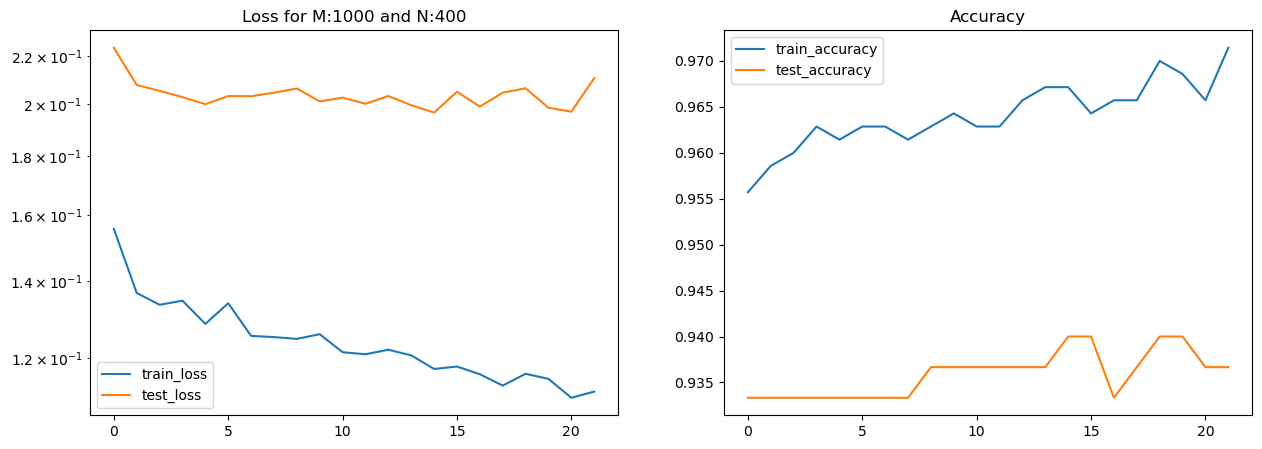

I0000 00:00:1768406339.562336 3031573 mps_client.h:209] MetalClient destroyed.
I0000 00:00:1768406339.562797 3031568 mps_client.h:209] MetalClient destroyed.
I0000 00:00:1768406339.563355 3031567 mps_client.h:209] MetalClient destroyed.
I0000 00:00:1768406339.566468 3031571 mps_client.h:209] MetalClient destroyed.


KeyboardInterrupt: 

In [ ]:
prior_bounds = jnp.array([[ranges[n][0], ranges[n][1]] for n in param_names])
mins = jnp.array([ranges[n][0] for n in param_names])
maxs = jnp.array([ranges[n][1] for n in param_names])

theta_init_next = jnp.array([
            0.5 * (ranges[n][0] + ranges[n][1])
            for n in param_names
        ])

# Persistent indices for train/test
train_idx_total = jnp.array([], dtype=int)
test_idx_total = jnp.array([], dtype=int)
N_total = 0  # total number of points added so far

for r in range(n_rounds):
    print(f"\n=== Sequential round {r+1} ===")

    # --------------------------------------------
    # 1. Posterior inference on fixed reference
    # --------------------------------------------
    print("Infering posterior...")

    for model_g in models_per_group:
        model_g.eval()  # disable dropout

    with jax.default_device(cpu):
        if r == 0:
            # First round: draw uniformly from prior
            key, subkey = jax.random.split(key)
            theta_post = prior_bounds[:, 0] + (prior_bounds[:, 1] - prior_bounds[:, 0]) * jax.random.uniform(
                subkey, shape=(N_post, len(param_names))
            )
            theta_init_next = jnp.mean(theta_post, axis=0)
        else:
            # Sample from posterior using trained models
            def log_post(theta):
                return nnte.log_prob_fn_groups(
                    theta, models_per_group, ref_data, prior_bounds, param_groups, param_names
                )
            
            theta_init = theta_init_next
            key, post = nnte.sample_posterior(
                log_post,
                n_warmup=200,
                n_samples=N_post,
                init_position=theta_init,
                rng_key=key
            )
            theta_post = post
            theta_init_next = jnp.mean(theta_post, axis=0)

    print("... done")

    # --------------------------------------------
    # 2. Simulate new data
    # --------------------------------------------
    print("Compute new simulations ...")
    params_post = {name: theta_post[:, i] for i, name in enumerate(param_names)}
    
    params_post_sim = params_post.copy()
    params_post_sim['mabs'] = params_post_sim['mabs'] + mabs_offset


    results_post = Parallel(n_jobs=8)(
        delayed(gsim.simulate_one)(
            {k: v[i] for k, v in params_post_sim.items()},
            z_max=z_max,
            M=M,
            cols=columns,
            N=N_post,
            i=i
        ) for i in range(N_post)
    )
    print("... done")

    # --------------------------------------------
    # 3. Append new data to HDF5 with cosmology removal
    # --------------------------------------------
    with h5py.File(file_path, "a") as f:
        # Append parameters
        for k, v in params_post.items():
            
            if r == 0 and k == "mabs":
                new = v
                old = f[f"params/mabs"][:]
                f[f"params/mabs"].resize((old.shape[0] + new.shape[0]), axis=0)
                f[f"params/mabs"][-new.shape[0]:] = new
            else:
                v = jnp.array(v)
                old = f[f"params/{k}"][:]
                f[f"params/{k}"].resize((old.shape[0] + v.shape[0]), axis=0)
                f[f"params/{k}"][-v.shape[0]:] = v
                
        # Append data
        # Extract new z and magobs
        z_new = jnp.stack([jnp.array(res["z"]) for res in results_post], axis=0)
        for k in results_post[0].keys():
            new = jnp.stack([jnp.array(res[k]) for res in results_post], axis=0)

            if k == "magobs":
                # Apply cosmology correction only on new magobs
                _, new = nntr.rm_cosmo(z_new, new, z_max=0.2, n_grid=10_000)

                # Save z_new to HDF5
                old = f["data/magobs"][:]
                f["data/magobs"].resize((old.shape[0] + new.shape[0]), axis=0)
                f["data/magobs"][-new.shape[0]:] = new
            else:
                old = f[f"data/{k}"][:]
                f[f"data/{k}"].resize((old.shape[0] + new.shape[0]), axis=0)
                f[f"data/{k}"][-new.shape[0]:] = new

    print("... done")

    # --------------------------------------------
    # 4. Reload dataset
    # --------------------------------------------
    print("Reload full dataset ...")
    with h5py.File(file_path, "r") as f:
        params = {k: jnp.array(f[f"params/{k}"][:]) for k in f["params"].keys()}
        data   = {k: jnp.array(f[f"data/{k}"][:]) for k in f["data"].keys()}

    N = next(iter(params.values())).shape[0]
    M = next(iter(data.values())).shape[1]

    magobs = data["magobs"]
    mask = magobs != 0
    data_padded = {k: jnp.where(mask, v, 0) for k, v in data.items()}
    param_true = jnp.stack([params[n] for n in param_names], axis=1)

    # Parameter coverage plot
    pairs = list(itertools.combinations(range(len(param_names)), 2))
    fig_cov, axes = plt.subplots(nrows=len(pairs), ncols=1, figsize=(6, 3*len(pairs)))
    axes = [axes] if len(pairs) == 1 else axes
    for ax, (i, j) in zip(axes, pairs):
        ax.scatter(param_true[:, i], param_true[:, j], s=5, alpha=0.6, c="#1F487E")
        ax.set_xlabel(param_names[i])
        ax.set_ylabel(param_names[j])
    fig_cov.suptitle(f"Parameter space coverage — Round {r+1}", fontsize=14)
    plt.savefig(os.path.join(post_dir, f"posterior_round_{r+1}.png"), dpi=150)
    print(f"Posterior plot saved at: {os.path.join(post_dir, f'posterior_round_{r+1}.png')}")

    data_concat = jnp.concatenate([data_padded[k] for k in data_padded.keys()], axis=-1)

    # --------------------------------------------
    # 5. Build datasets per group
    # --------------------------------------------
    all_group_datasets = []
    for g, group in enumerate(param_groups):
        group_list = [group] if isinstance(group, str) else group
        group_idx = jnp.array([param_names.index(name) for name in group_list], dtype=int)
        prev_groups = [p for i in range(g) for p in (param_groups[i] if isinstance(param_groups[i], list) else [param_groups[i]])]
        prev_idx = jnp.array([param_names.index(p) for p in prev_groups], dtype=int) if prev_groups else jnp.array([], dtype=int)

        key, label_key = jax.random.split(key)
        labels = jax.random.uniform(label_key, (N,)) > 0.5

        key, lhs_key = jax.random.split(key)
        lhs = nntr.lhs_jax(lhs_key, K, N)
        false_params = mins + (maxs - mins) * lhs

        params_group = jnp.array(param_true)
        chosen = jnp.where(labels[:, None], param_true[:, group_idx], false_params[:, group_idx])
        params_group = params_group.at[:, group_idx].set(chosen)

        visible_idx = jnp.concatenate([prev_idx, group_idx]) if prev_idx.size > 0 else group_idx
        params_visible = params_group[:, visible_idx]

        inputs_g = jnp.concatenate([data_concat, mask, params_visible], axis=-1)
        outputs_g = labels.astype(jnp.int32)[:, None]

        all_group_datasets.append((inputs_g, outputs_g))

    print("... done")

    # --------------------------------------------
    # 6. Train models
    # --------------------------------------------
    print("Train NNs ...")
    for model_g in models_per_group:
        model_g.train()

    for g, (inputs_g, outputs_g) in enumerate(all_group_datasets):
        model = models_per_group[g]

        optimizer = nnx.Optimizer(model, optax.adamw(5e-5, 0.9))

        inputs_cpu = jax.device_put(inputs_g, cpu)
        outputs_cpu = jax.device_put(outputs_g, cpu)

        # ---- NEW TRAIN/TEST SPLIT: only on new data ----
        N_new = inputs_cpu.shape[0]
        key, split_key = jax.random.split(key)
        tr_x_new, te_x_new, tr_y_new, te_y_new = nntr.train_test_split_jax(inputs_cpu, outputs_cpu, test_size=0.3, shuffle=True, key=split_key)

        # Indices relative to current dataset
        new_indices = jnp.arange(N_total, N_total + N_new)
        train_idx_new = new_indices[:tr_x_new.shape[0]]
        test_idx_new  = new_indices[tr_x_new.shape[0]:]

        train_idx_total = jnp.concatenate([train_idx_total, train_idx_new])
        test_idx_total  = jnp.concatenate([test_idx_total, test_idx_new])
        N_total += N_new

        # Build full train/test sets from persistent indices
        tr_x = inputs_cpu[train_idx_total - (N_total - N_new)]
        tr_y = outputs_cpu[train_idx_total - (N_total - N_new)]
        te_x = inputs_cpu[test_idx_total - (N_total - N_new)]
        te_y = outputs_cpu[test_idx_total - (N_total - N_new)]

        model, _, key = nntr.train_loop(
            model=model,
            optimizer=optimizer,
            train_data=tr_x,
            train_labels=tr_y,
            test_data=te_x,
            test_labels=te_y,
            key=key,
            epochs=100,
            batch_size=max(tr_x.shape[0] // 100, 20),
            patience=20,
            metrics_history={'train_loss':[], 'train_accuracy':[], 'test_loss':[], 'test_accuracy':[]},
            M=M,
            N=N,
            cpu=cpu,
            gpu=gpu,
            group_id=g,
            group_params=param_groups[g],
            plot_flag=True,
        )

        # plt.savefig(os.path.join(train_dir, f"group_{g}_round_{r+1}.png"), dpi=15)

        models_per_group[g] = model  # replace old model

    print("... done")
